In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model,manifold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import seaborn as sns
import copy
#import pylab
#Project functions
from Project_functions import get_monthi,get_mean_temp

In [2]:
#setup
df = pd.read_csv("consumption.csv")
weather_avg = pd.read_csv('weather-avg.csv')
weather_min = pd.read_csv('weather-min.csv')
weather_max = pd.read_csv('weather-max.csv')
info = pd.read_csv('addinfo.csv')
weather_avg = weather_avg.set_index("meter_id")
weather_min = weather_min.set_index("meter_id")
weather_max = weather_max.set_index("meter_id")
info = info.set_index("meter_id")
weather_avg_sorted = weather_avg.reindex(df.iloc[:,0])
weather_min_sorted = weather_min.reindex(df.iloc[:,0])
weather_max_sorted = weather_max.reindex(df.iloc[:,0])
info_sorted = info.reindex(df.iloc[:,0])
brinfo=info_sorted['num_bedrooms']
values = {'num_bedrooms' : brinfo.mean()}
info_filled_br = info_sorted.fillna(value = values)
brinfo_filled = info_filled_br['num_bedrooms']

In [3]:
#these don't work out of the function file apperantly
def Eval_random_Split(features,npEn_con,split,model,print_res=True):
    X_train, X_test, y_train, y_test = train_test_split(
    features , npEn_con, test_size=split, random_state=0)
    #print(X_train.shape, y_train.shape)
    #print(X_test.shape, y_test.shape)
    model.fit(X_train,y_train)
    if print_res:
        y_pred=model.predict(X_test)
        print('Coefficients: \n', model.coef_)
        print('Intercept: {}'.format(model.intercept_))
        # The mean squared error
        print('Mean squared error: %.8f' % mean_squared_error(y_test, y_pred))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: %.8f' % r2_score(y_test, y_pred))
    return model

def Check_1D(features,npEn_con,split,model,print_res=True):
    #extract only the last month from the features
    features_lm=features[:,(features.shape[-1]-1)]
    features_lm=features_lm.reshape(-1,1)
    #use previously made function
    return Eval_random_Split(features_lm,npEn_con,split,model,print_res)

#z-normalization on data:
def normalise_features(np_features):
    #np_features_norm= np.zeros(shape = np_features.shape)
    np_features_norm=np_features
    if np_features.ndim==1:
        np_features_norm=(np_features-np.mean(np_features))/np.std(np_features)
    else: 
        for i in range(np_features.shape[1]):
            np_features_norm[:,i] = (np_features[:,i]-np.mean(np_features[:,i]))/np.std(np_features[:,i])
    return np_features_norm

def Eval_Kfold_Split(features,npEn_con,n_splits,model,print_res=True):
    kf = KFold(n_splits, shuffle=True)
    models_arr=[]
    MSE_arr=[]
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        cmodel=model
        cmodel.fit(features[train_index,],npEn_con[train_index])
        models_arr.append(cmodel)
        y_pred = cmodel.predict(features[test_index,])
        MSE_arr.append(mean_squared_error(npEn_con[test_index,], y_pred));
        R2_arr.append(r2_score(npEn_con[test_index,], y_pred))
    if print_res:
        # The mean squared error
        print('Mean squared error:')
        print(np.mean(MSE_arr))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))
    return models_arr,np.mean(R2_arr)

In [4]:
def sort_data(nim,nom,combine_output=False):
    #nim: number of input months
    #nom: number of output months
    
    #CHECK INPUTS
    if nim<1:
        print("number of input months (nim) should be greater or equal to 1")
        return 0
    if nom<1:
        print("number of output months (nom) should be greater or equal to 1")
        return 0
    
    #DATA STORAGE
    En_con=[]        #current/future consumption (this is what we try to predict)
    prev_con=[]      #previous consumption
    prev_daily_con=[]  #previous consumption on a daily basis
    #extra info
    temps=[]
    temps_min=[]
    temps_max=[]
    month_arr=[]
    br_arr=[]       #Bedroom info array
    br_arr_mean=[]
    dwt_arr=[]      #dwelling type array
    y = pd.get_dummies(info_sorted.dwelling_type, prefix='dwelling_type')
    
    #LOOP
    NaN_t=1200  #thershold
    #NaN_day_T=20 #the amount of days of data we want in a input month(28 days)
    for i in range(df.shape[0]): # loop over all users
        meter=df.iloc[i] # = row number i  
    
        #loop over all month from januari until month 14-nim-nom
        #if the month is higher then this we don't have enough data for the nim input and nom output variables
        #in the case of nim=1 nom=1 we get range(1,12) wich result in m going from 1 to 11 like we want
        for m in range (1,14-nim-nom): 
            #load current month
            bi, ei =get_monthi(m)    #bi (begin index) ei(end index)
            month=meter[bi:ei]       #data for the month m for the row user (row) i
            #load bedroom info
            row = brinfo[i:i+1]               #bedroom info with NaN values
            row_mean = brinfo_filled[i:i+1]  #bedroom info with mean values
            #Load dwelling type
            dew_type_row = y[i:i+1]
            
            # Count the amount of NaN's in all months that will be used
            n_NaN=0
            for k in range(nim+nom):
                bi, ei =get_monthi(m+k)        #bi (begin index) ei(end index)
                tempmonth=meter[bi:ei]       #data for the month m for the row user (row) i
                n_NaN+=tempmonth.isnull().sum() 
            
            if n_NaN<NaN_t:
                #save input for month j,j+1,..,j+nim-1
                input_months=np.zeros(nim)
                input_days=np.zeros([nim,28])
                input_temps=np.zeros(nim)
                input_temps_min=np.zeros(nim)
                input_temps_max=np.zeros(nim)
                output_months=np.zeros(nom)
                output_temps=np.zeros(nom)
                output_temps_min=np.zeros(nom)
                output_temps_max=np.zeros(nom)
                for k in range(nim):
                    #load month for input j+k (k goes from 0 to nim-1)
                    bik,eik=get_monthi(m+k)
                    input_months[k]=meter[bik:eik].mean()
                    daily_con=np.zeros(28)
                    current_month=meter[bik:eik]
                    #print(current_month)
                    #save daily data
                    for d in range(28):
                        daily_con[d]=current_month[d*48:(d+1)*48].mean()
                        input_days[k,:]=daily_con
                    #replace all NaN with the mean value
                    input_days[k,np.isnan(input_days[k,:])]=input_months[k] 
                    #temperatures
                    input_temps[k]=get_mean_temp(weather_avg_sorted.iloc[i:i+1],m+k)
                    input_temps_min[k]=get_mean_temp(weather_min_sorted.iloc[i:i+1],m+k)
                    input_temps_max[k]=get_mean_temp(weather_max_sorted.iloc[i:i+1],m+k)
                for k in range(nom):
                    #load month for input j+nim+k
                    bik,eik=get_monthi(m+nim+k)
                    output_months[k]=meter[bik:eik].mean()
                    #temps
                    output_temps[k]=get_mean_temp(weather_avg_sorted.iloc[i:i+1],m+nim+k)
                    output_temps_min[k]=get_mean_temp(weather_min_sorted.iloc[i:i+1],m+nim+k)
                    output_temps_max[k]=get_mean_temp(weather_max_sorted.iloc[i:i+1],m+nim+k)
                #debug if statement checks for NaN in input month
#                 if np.isnan(np.sum(input_months)):
#                     print("input month has nan value for months=%i index=%i" %(m,i))
#                     print(input_months)
#                     return 1
#                 if np.isnan(np.sum(np.sum(input_days))):
#                     print("input days has nan value for months=%i index=%i" %(m,i))
#                     print(input_days)
#                     return 1
#                 if np.isnan(np.sum(output_months)):
#                     print("Output months has nan value for months=%i index=%i" %(m,i))
#                     print(output_months)
#                     return 1
                #store Energy consumption data
                prev_con.append(input_months)
                prev_daily_con.append(input_days)
                En_con.append(output_months)
                #save extra information 
                temps.append(np.concatenate((input_temps,output_temps)))
                temps_min.append(np.concatenate((input_temps_min,output_temps_min)))
                temps_max.append(np.concatenate((input_temps_max,output_temps_max)))
                month_arr.append(m+nim)
                #bedroom info
                n_br=row[0]
                br=np.zeros(5)
                if ~np.isnan(n_br):
                    #print(n_br)
                    br[np.int(n_br-1)]=1
                br_arr.append(br)
                br_arr_mean.append(row_mean[0])
                #dwelling type
                dwt_arr.append(dew_type_row.to_numpy().ravel())
                        
                #break out of outer month loops since the inner month loop takes care of all months
                #break
                
    # converting list to numpy arrays: 
    npEn_con=np.array(En_con)
    npprev_con=np.array(prev_con)
    npprev_daily_con=np.array(prev_daily_con)
    nptemps=np.array(temps)
    nptemps_min=np.array(temps_min)
    nptemps_max=np.array(temps_max)
    npmonth=np.array(month_arr)
    npbr=np.array(br_arr)
    npbrmean=np.array(br_arr_mean)
    npdwt=np.array(dwt_arr)
    
    #This should probably be done differently 
    if combine_output:
        return [npEn_con,npprev_con,npprev_daily_con,nptemps,nptemps_min,nptemps_max,npmonth,npbr,npbrmean,npdwt]
    else:
        return npEn_con,npprev_con,npprev_daily_con,nptemps,nptemps_min,nptemps_max,npmonth,npbr,npbrmean,npdwt

In [5]:
data11=sort_data(1,1,True)

In [159]:
data23=sort_data(2,3,True)

In [5]:
def run_basic_tests(data,nim,model,pr=True,ran_s=False):
    R2_arr=[]
    #model=LinearRegression()
    if pr:
        print('#####################################')
        print('0) Using only energy consumption')
        print('#####################################')
    mod,R2=Eval_Kfold_Split(data[1],data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('1) Include input mean temperature')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('2) Include all average temprature info (FUTURE INFO)')
        print('#####################################')
    features=np.column_stack(((data[1],data[3])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('3) Include all input temprature info')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],data[5][:,np.arange(0,nim)])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('4) Include all temprature info(FUTURE INFO)')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],data[5])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('5) Include all input temprature info (one hot enconding br)')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[7])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('6) Include all input temprature info (mean br)')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[8])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('7) Include all input temprature info + dwellling type')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[9])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('8) Include all input temprature info + (one hot enconding br)+dwellling type')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[7],data[9])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('9) Include all input temprature info + mean br+dwellling type')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[8],data[9])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('10) Include all info (one hot enconding br) (FUTURE INFO)')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],data[5],data[7],data[9])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('11) Include all info (mean br) (FUTURE INFO)')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],data[5],data[8],data[9])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if ran_s:
        print('\n#####################################')
        print('Random split coefficient test')
        print('#####################################')
        features=np.column_stack(((data[1],data[3],data[4],data[5],data[6],data[7],data[8],data[9])))
        mod=Eval_random_Split(features,data[0],0.3,model,print_res=True)
        print('\nusing only input temprature')
        features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],data[5][:,np.arange(0,nim)],data[6],data[7],data[8],data[9])))
        mod=Eval_random_Split(features,data[0],10,model,print_res=True)
    return R2_arr

### data11

<AxesSubplot:>

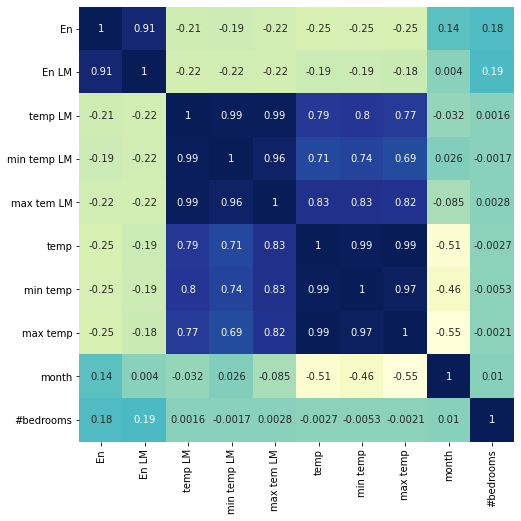

In [8]:
#Correlation plot
templm=data11[3][:,0] 
temp=data11[3][:,1] 
mintemplm=data11[4][:,0] 
mintemp=data11[4][:,1] 
maxtemplm=data11[5][:,0] 
maxtemp=data11[5][:,1] 
#df2 = pd.DataFrame(data=np.transpose(np.array([data11[0], data11[1], data11[3] ])[:,:,0]),
#                   columns=['Energy consumption', 'Energy consumption lm', 'temp lm'])
df2 = pd.DataFrame(data=np.transpose(np.array([data11[0].ravel() , data11[1].ravel() , templm, mintemplm,
                                               maxtemplm, temp, mintemp, maxtemp, data11[6].ravel(),data11[8].ravel()])),
                   columns=['En', 'En LM', 'temp LM','min temp LM','max tem LM', 'temp', 'min temp',
                            'max temp','month','#bedrooms'])
corr=df2.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), square=True, ax=ax,cmap="YlGnBu",annot=True,cbar=False)
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#            square=True, ax=ax)

<AxesSubplot:>

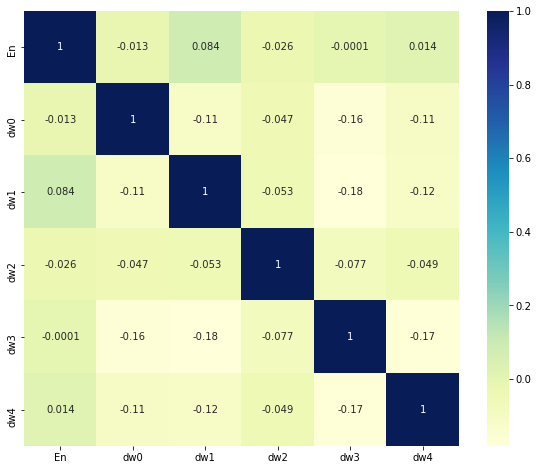

In [9]:
#Correlation plot dwelling types
dw0=data11[9][:,0]
dw1=data11[9][:,1]
dw2=data11[9][:,2]
dw3=data11[9][:,3]
dw4=data11[9][:,4]
#df2 = pd.DataFrame(data=np.transpose(np.array([data11[0], data11[1], data11[3] ])[:,:,0]),
#                   columns=['Energy consumption', 'Energy consumption lm', 'temp lm'])
df2 = pd.DataFrame(data=np.transpose(np.array([data11[0].ravel(), dw0, dw1 , dw2,dw3,dw4])),
                   columns=['En','dw0','dw1','dw2','dw3','dw4'])
corr=df2.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), square=True, ax=ax,cmap="YlGnBu",annot=True)

In [235]:
model=LinearRegression()
R2_arr_linreg=run_basic_tests(data11,1,model,pr=True,ran_s=True)
print(R2_arr_linreg)

#####################################
0) Using only energy consumption
#####################################
Mean squared error:
0.16364363482837083
Coefficient of determination: 
0.835680181961974

#####################################
1) Include input temperature
#####################################
Mean squared error:
0.1636054157685931
Coefficient of determination: 
0.8361592603612179

#####################################
2) Include all average temprature info (FUTURE INFO)
#####################################
Mean squared error:
0.14713900231745866
Coefficient of determination: 
0.8527708598826778

#####################################
3) Include all input temprature info
#####################################
Mean squared error:
0.15897923948858822
Coefficient of determination: 
0.8396502510489154

#####################################
4) Include all temprature info(FUTURE INFO)
#####################################
Mean squared error:
0.14429052020091257
Coefficient of determi

The is some over fitting in the random split test the coefficient get very large a more restrictive linearregression model should be used like lasso

In [11]:
model=Ridge()
R2_arr_ridge=run_basic_tests(data11,1,model,pr=True,ran_s=True)
print(R2_arr_ridge)

#####################################
0) Using only energy consumption
#####################################
Mean squared error:
0.0032820176553817666
Coefficient of determination: 
0.8363547967512416

#####################################
1) Include input temperature
#####################################
Mean squared error:
0.003282391432547728
Coefficient of determination: 
0.835993074583828

#####################################
2) Include all average temprature info (FUTURE INFO)
#####################################
Mean squared error:
0.002954895185311861
Coefficient of determination: 
0.8513426097736255

#####################################
3) Include all input temprature info
#####################################
Mean squared error:
0.003189978024744456
Coefficient of determination: 
0.8406180063269421

#####################################
4) Include all temprature info(FUTURE INFO)
#####################################
Mean squared error:
0.0028930236849476565
Coefficient of

In [12]:
#model=Lasso(alpha=0.001) ridge works better
#R2_arr=run_basic_tests(data11,1,model)
#print(R2_arr)

It is best for a Ridge model that the in and output is normalised so we'll do this

In [8]:
def normalisedata(data):
    datanorm=data
    for i in range(len(data)):
        #noramlise all non one hot encoded variables
        if i != 7 and i != 9:
            datanorm[i]=normalise_features(datanorm[i])
    return datanorm

In [14]:
data11norm=normalisedata(data11)

In [15]:
print(data11[1])

[[-0.26956455]
 [-0.16508723]
 [ 0.40446142]
 ...
 [-0.10764604]
 [ 0.38102557]
 [ 1.37464254]]


In [16]:
print(data11norm[1])

[[-0.26956455]
 [-0.16508723]
 [ 0.40446142]
 ...
 [-0.10764604]
 [ 0.38102557]
 [ 1.37464254]]


In [29]:
model=Ridge()
R2_arr_ridge_norm=run_basic_tests(data11norm,1,model,pr=True,ran_s=True)
print(R2_arr_ridge_norm)


#####################################
Random split coefficient test
#####################################
Coefficients: 
 [[ 0.89933927  0.34854618  0.06582739 -0.19478485  0.00183578 -0.0490264
  -0.21231994  0.06445333  0.00275203 -0.00958868 -0.02110961 -0.02143851
   0.01005561  0.01330504  0.00404514 -0.02166073  0.02825433 -0.0068728
   0.00211494]]
Intercept: [0.0106838]
Mean squared error: 0.14284598
Coefficient of determination: 0.86322690

using only input temprature
Coefficients: 
 [[ 9.12826982e-01  2.93726833e-01 -8.46139520e-02 -2.11274391e-01
   1.30976299e-01  4.03458711e-03 -1.06185605e-02 -1.83763466e-02
  -1.80039577e-02  7.61173911e-03  6.93789732e-03  9.64127941e-03
  -1.31912288e-03  1.34479870e-02 -6.16604832e-04  1.02138827e-02]]
Intercept: [0.00745923]
Mean squared error: 0.06053646
Coefficient of determination: 0.71322166
[0.8363659492095902, 0.835537482925927, 0.8535653088040311, 0.8401385950629683, 0.8553405394642851, 0.8389613058043708, 0.8408924331763646,

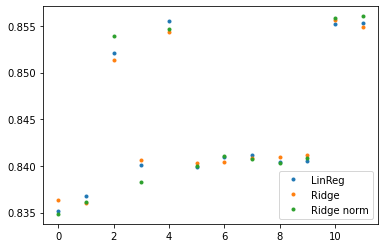

In [18]:
plt.plot(R2_arr_linreg,label='LinReg',marker='.',linestyle = 'None')
plt.plot(R2_arr_ridge,label='Ridge', marker='.',linestyle = 'None')
plt.plot(R2_arr_ridge_norm,label='Ridge norm',marker='.',linestyle = 'None')
plt.legend()
plt.show()

In [19]:
    print('0) Using only energy consumption')
    print('1) Include input temperature')
    print('2) Include all average temprature info (FUTURE INFO)')
    print('3) Include all input temprature info')
    print('4) Include all temprature info(FUTURE INFO)')
    print('5) Include all input temprature info (one hot enconding br)')
    print('6) Include all input temprature info (mean br)')
    print('7) Include all input temprature info + dwellling type')
    print('8) Include all input temprature info + (one hot enconding br)+dwellling type')
    print('9) Include all input temprature info + mean br+dwellling type')
    print('10) Include all info (one hot enconding br) (FUTURE INFO)')
    print('11) Include all info (mean br) (FUTURE INFO)')


0) Using only energy consumption
1) Include input temperature
2) Include all average temprature info (FUTURE INFO)
3) Include all input temprature info
4) Include all temprature info(FUTURE INFO)
5) Include all input temprature info (one hot enconding br)
6) Include all input temprature info (mean br)
7) Include all input temprature info + dwellling type
8) Include all input temprature info + (one hot enconding br)+dwellling type
9) Include all input temprature info + mean br+dwellling type
10) Include all info (one hot enconding br) (FUTURE INFO)
11) Include all info (mean br) (FUTURE INFO)


To put in paper <br>
The result of only temp and only En con <br>
necessity of Ridge <br>
The best performing set of features and maybe some others in a table <br>
To do<br>
optimise ridge

In [20]:
def opt_Ridge(features,En,astart,aend,steps):
    R2_arr=[]
    a_arr=np.linspace(astart,aend,steps)
    for a in a_arr:
        model=Ridge(alpha=a)
        mod,R2=Eval_Kfold_Split(features,En,50,model,print_res=False)
        R2_arr.append(R2)
    alphamax=a_arr[np.argmax(R2_arr)]
    return alphamax,R2_arr,a_arr
    

In [21]:
nim=1
features=np.column_stack(((data11norm[1],data11norm[3][:,np.arange(0,nim)],data11norm[4][:,np.arange(0,nim)],
                               data11norm[5][:,np.arange(0,nim)],data11norm[7],data11norm[9])))
alphamax,R2_arr,a_arr=opt_Ridge(features,data11norm[0],0,0.1,400)
print(alphamax)

0.006015037593984963


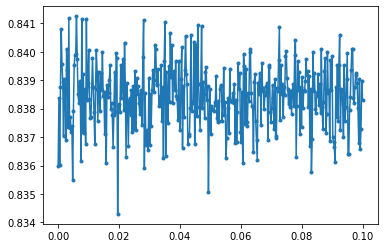

In [22]:
plt.plot(a_arr,R2_arr,marker='.')
plt.show()

5.81453634085213


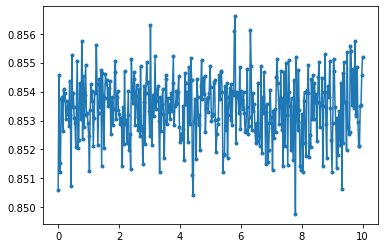

In [23]:
#other test
nim=1
features=np.column_stack(((data11norm[1],data11norm[3],data11norm[4],data11norm[5]
                           ,data11norm[7],data11norm[9])))
alphamax,R2_arr,a_arr=opt_Ridge(features,data11norm[0],0,10,400)
print(alphamax)
plt.plot(a_arr,R2_arr,marker='.')
plt.show()

To noisy no real improvement for any value. any value seems okay as long as it's not too large like 100. We'll keep the default value of 1

### data 23

In [24]:
data23norm=normalisedata(data23)
model=Ridge()
R2_arr=run_basic_tests(data23,2,model)
print(R2_arr)

#####################################
0) Using only energy consumption
#####################################
Mean squared error:
0.32337263822255646
Coefficient of determination: 
0.6777074135399013

#####################################
1) Include input temperature
#####################################
Mean squared error:
0.2874038334301052
Coefficient of determination: 
0.7144459837554302

#####################################
2) Include all average temprature info (FUTURE INFO)
#####################################
Mean squared error:
0.2824215308779344
Coefficient of determination: 
0.718387623928345

#####################################
3) Include all input temprature info
#####################################
Mean squared error:
0.28586466966031926
Coefficient of determination: 
0.7140202156596615

#####################################
4) Include all temprature info(FUTURE INFO)
#####################################
Mean squared error:
0.2819462948677268
Coefficient of determina

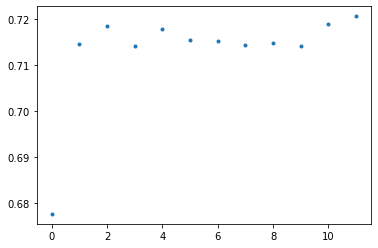

In [25]:
plt.plot(R2_arr,marker='.',linestyle = 'None')

plt.show()

## Loop over nim and nom combinations

In [6]:
def run_paper_tests(data,nim,model,pr=True):
    R2_arr=[]
    #model=LinearRegression()
    if pr:
        print('#####################################')
        print('0) Using only energy consumption')
        print('#####################################')
    mod,R2=Eval_Kfold_Split(data[1],data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('1) Include input mean temperature')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('2) Include all input temprature info')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],data[5][:,np.arange(0,nim)])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('3) Include all input temprature info + (one hot enconding br)+dwellling type')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[7],data[9])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('4) Include all temprature info(FUTURE INFO)')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],data[5])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    if pr:
        print('\n#####################################')
        print('5) Include all info (one hot enconding br) (FUTURE INFO)')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],data[5],data[7],data[9])))
    mod,R2=Eval_Kfold_Split(features,data[0],10,model,print_res=pr)
    R2_arr.append(R2)
    return R2_arr

In [ ]:
#organise data (This takes really long)
nim_arr=[1, 2, 3, 6]
nom_arr=[1, 2, 3, 6]
data_arr=[]
for nim in nim_arr:
    for nom in nom_arr:
        data=[]
        data.append(nim)
        data.append(nom)
        data.append(normalisedata(sort_data(nim,nom,True)))
        data_arr.append(data)

In [236]:
#run tests
R2_arr=[]
for data in data_arr:
    if not(data[0] ==6 and data[1] == 6):
        model=Ridge()
        R2_arr.append(run_paper_tests(data[2],data[0],model,pr=False))

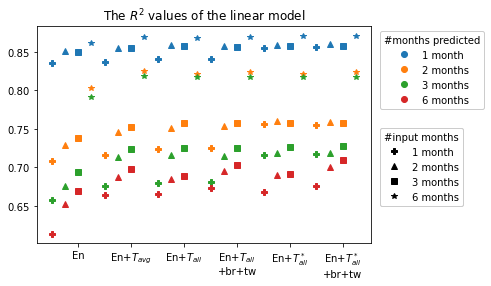

In [237]:
fig, ax = plt.subplots()
plt.plot(R2_arr[0],marker='P',linestyle = 'None',color='tab:blue')
plt.plot(R2_arr[1],marker='P',linestyle = 'None',color='tab:orange')
plt.plot(R2_arr[2],marker='P',linestyle = 'None',color='tab:green')
plt.plot(R2_arr[3],marker='P',linestyle = 'None',color='tab:red')
offset_2inputs=np.linspace(0,5,6)+0.25
plt.plot(offset_2inputs,R2_arr[4],marker='^',linestyle = 'None',color='tab:blue')
plt.plot(offset_2inputs,R2_arr[5],marker='^',linestyle = 'None',color='tab:orange')
plt.plot(offset_2inputs,R2_arr[6],marker='^',linestyle = 'None',color='tab:green')
plt.plot(offset_2inputs,R2_arr[7],marker='^',linestyle = 'None',color='tab:red')
offset_3inputs=np.linspace(0,5,6)+0.5
plt.plot(offset_3inputs,R2_arr[8],marker='s',linestyle = 'None',color='tab:blue')
plt.plot(offset_3inputs,R2_arr[9],marker='s',linestyle = 'None',color='tab:orange')
plt.plot(offset_3inputs,R2_arr[10],marker='s',linestyle = 'None',color='tab:green')
plt.plot(offset_3inputs,R2_arr[11],marker='s',linestyle = 'None',color='tab:red')
offset_6inputs=np.linspace(0,5,6)+0.75
plt.plot(offset_6inputs,R2_arr[12],marker='*',linestyle = 'None',color='tab:blue')
plt.plot(offset_6inputs,R2_arr[13],marker='*',linestyle = 'None',color='tab:orange')
plt.plot(offset_6inputs,R2_arr[14],marker='*',linestyle = 'None',color='tab:green')

plt.title('The $R^2$ values of the linear model')

#legend
markers=["P","^","s","*"]
colors=['tab:blue','tab:orange','tab:green','tab:red']

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(4)]
handles2 = [f(markers[i], "k") for i in range(4)]
labels = ['1 month','2 months','3 months','6 months']

legend1=ax.legend(handles1, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles2, labels, framealpha=1,title='#input months',bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5],['En','En+$T_{avg}$','En+$T_{all}$','En+$T_{all}$ \n+br+tw' ,
                                           'En+$T_{all}^*$','En+$T_{all}^*$ \n+br+tw'])
plt.show()

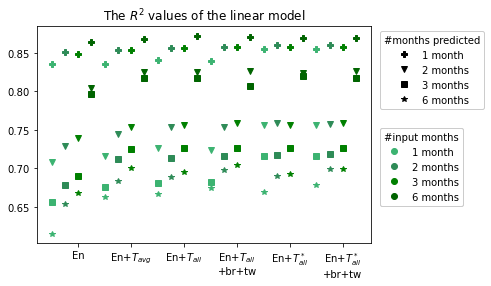

In [148]:
#colors=['greenyellow','yellowgreen','olivedrab','darkolivegreen']
colors=['mediumseagreen','seagreen','green','darkgreen']
fig, ax = plt.subplots()
plt.plot(R2_arr[0],marker='P',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[1],marker='v',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[2],marker='s',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[3],marker='*',linestyle = 'None',color=colors[0])
offset_2inputs=np.linspace(0,5,6)+0.25
plt.plot(offset_2inputs,R2_arr[4],marker='P',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr[5],marker='v',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr[6],marker='s',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr[7],marker='*',linestyle = 'None',color=colors[1])
offset_3inputs=np.linspace(0,5,6)+0.5
plt.plot(offset_3inputs,R2_arr[8],marker='P',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr[9],marker='v',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr[10],marker='s',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr[11],marker='*',linestyle = 'None',color=colors[2])
offset_6inputs=np.linspace(0,5,6)+0.75
plt.plot(offset_6inputs,R2_arr[12],marker='P',linestyle = 'None',color=colors[3])
plt.plot(offset_6inputs,R2_arr[13],marker='v',linestyle = 'None',color=colors[3])
plt.plot(offset_6inputs,R2_arr[14],marker='s',linestyle = 'None',color=colors[3])

plt.title('The $R^2$ values of the linear model')

#legend
markers=["P","v","s","*"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(4)]
handles2 = [f(markers[i], "k") for i in range(4)]
labels = ['1 month','2 months','3 months','6 months']

legend1=ax.legend(handles2, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles1, labels, framealpha=1,title='#input months',bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5],['En','En+$T_{avg}$','En+$T_{all}$','En+$T_{all}$ \n+br+tw' ,
                                           'En+$T_{all}^*$','En+$T_{all}^*$ \n+br+tw'])
plt.show()

### 1 dim test


In [216]:
#A test to see if the result is influence by the smaller data set
R2_arr_1D=[]
for data in data_arr:
    if data[0] != 1:
        if not(data[0] ==6 and data[1] == 6):
            model=Ridge()
            nim=data[0]
            nom=data[1]
            data1D=copy.deepcopy(data[2])
            data1D[1]=copy.deepcopy(data[2][1][:,-1].reshape(-1,1))
            data1D[3]=copy.deepcopy(data[2][3][:,np.arange(nim-1,nim+nom)])
            data1D[4]=copy.deepcopy(data[2][4][:,np.arange(nim-1,nim+nom)])
            data1D[5]=copy.deepcopy(data[2][5][:,np.arange(nim-1,nim+nom)])
            data1D=normalisedata(data1D)
            #print('nim=%i nom=%i' %(nim,nom))
            #print(data1D[1])
            #print(data1D[3])
            R2_arr_1D.append(run_paper_tests(data1D,1,model,pr=False))

In [217]:
R2np1D=np.array(R2_arr_1D)

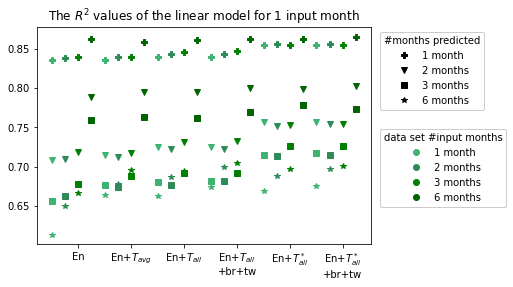

In [209]:
#colors=['greenyellow','yellowgreen','olivedrab','darkolivegreen']
colors=['mediumseagreen','seagreen','green','darkgreen']
fig, ax = plt.subplots()
plt.plot(R2_arr[0],marker='P',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[1],marker='v',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[2],marker='s',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[3],marker='*',linestyle = 'None',color=colors[0])
offset_2inputs=np.linspace(0,5,6)+0.25
plt.plot(offset_2inputs,R2_arr_1D[0],marker='P',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr_1D[1],marker='v',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr_1D[2],marker='s',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr_1D[3],marker='*',linestyle = 'None',color=colors[1])
offset_3inputs=np.linspace(0,5,6)+0.5
plt.plot(offset_3inputs,R2_arr_1D[4],marker='P',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr_1D[5],marker='v',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr_1D[6],marker='s',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr_1D[7],marker='*',linestyle = 'None',color=colors[2])
offset_6inputs=np.linspace(0,5,6)+0.75
plt.plot(offset_6inputs,R2_arr_1D[8],marker='P',linestyle = 'None',color=colors[3])
plt.plot(offset_6inputs,R2_arr_1D[9],marker='v',linestyle = 'None',color=colors[3])
plt.plot(offset_6inputs,R2np1D[10],marker='s',linestyle = 'None',color=colors[3])

plt.title('The $R^2$ values of the linear model for 1 input month')

#legend
markers=["P","v","s","*"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(4)]
handles2 = [f(markers[i], "k") for i in range(4)]
labels = ['1 month','2 months','3 months','6 months']

legend1=ax.legend(handles2, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles1, labels, framealpha=1,title='data set #input months',bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5],['En','En+$T_{avg}$','En+$T_{all}$','En+$T_{all}$ \n+br+tw' ,
                                           'En+$T_{all}^*$','En+$T_{all}^*$ \n+br+tw'])
plt.show()

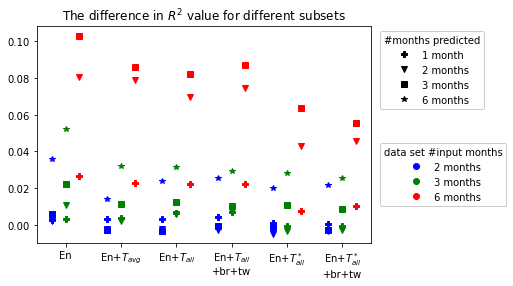

In [210]:
#colors=['seagreen','green','darkgreen']
colors=['b','g','r']
fig, ax = plt.subplots()
#plt.plot(R2_arr[0],marker='P',linestyle = 'None',color=colors[0])
#plt.plot(R2_arr[1],marker='v',linestyle = 'None',color=colors[0])
#plt.plot(R2_arr[2],marker='s',linestyle = 'None',color=colors[0])
#plt.plot(R2_arr[3],marker='*',linestyle = 'None',color=colors[0])
pred1month=np.array(R2_arr[0])
pred2month=np.array(R2_arr[1])
pred3month=np.array(R2_arr[2])
pred6month=np.array(R2_arr[3])
offset_2inputs=np.linspace(0,5,6)+0.25
plt.plot(offset_2inputs,R2np1D[0]-pred1month,marker='P',linestyle = 'None',color=colors[0])
plt.plot(offset_2inputs,R2np1D[1]-pred2month,marker='v',linestyle = 'None',color=colors[0])
plt.plot(offset_2inputs,R2np1D[2]-pred3month,marker='s',linestyle = 'None',color=colors[0])
plt.plot(offset_2inputs,R2np1D[3]-pred6month,marker='*',linestyle = 'None',color=colors[0])
offset_3inputs=np.linspace(0,5,6)+0.5
plt.plot(offset_3inputs,R2np1D[4]-pred1month,marker='P',linestyle = 'None',color=colors[1])
plt.plot(offset_3inputs,R2np1D[5]-pred2month,marker='v',linestyle = 'None',color=colors[1])
plt.plot(offset_3inputs,R2np1D[6]-pred3month,marker='s',linestyle = 'None',color=colors[1])
plt.plot(offset_3inputs,R2np1D[7]-pred6month,marker='*',linestyle = 'None',color=colors[1])
offset_6inputs=np.linspace(0,5,6)+0.75
plt.plot(offset_6inputs,R2np1D[8]-pred1month,marker='P',linestyle = 'None',color=colors[2])
plt.plot(offset_6inputs,R2np1D[9]-pred2month,marker='v',linestyle = 'None',color=colors[2])
plt.plot(offset_6inputs,R2np1D[10]-pred3month,marker='s',linestyle = 'None',color=colors[2])

plt.title('The difference in $R^2$ value for different subsets ')

#legend
markers=["P","v","s","*"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(3)]
handles2 = [f(markers[i], "k") for i in range(4)]
labelscolor = ['2 months','3 months','6 months']
labels = ['1 month','2 months','3 months','6 months']

legend1=ax.legend(handles2, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles1, labelscolor, framealpha=1,title='data set #input months',
                  bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5],['En','En+$T_{avg}$','En+$T_{all}$','En+$T_{all}$ \n+br+tw' ,
                                           'En+$T_{all}^*$','En+$T_{all}^*$ \n+br+tw'])
plt.show()

### Adjusted R2 plot

In [218]:
npR2=np.array(R2_arr)

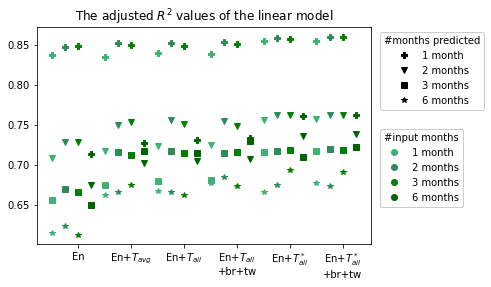

In [226]:
#colors=['greenyellow','yellowgreen','olivedrab','darkolivegreen']
colors=['mediumseagreen','seagreen','green','darkgreen']
fig, ax = plt.subplots()
plt.plot(R2_arr[0],marker='P',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[1],marker='v',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[2],marker='s',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[3],marker='*',linestyle = 'None',color=colors[0])
offset_2inputs=np.linspace(0,5,6)+0.25
plt.plot(offset_2inputs,npR2[4]-R2np1D[0]+pred1month,marker='P',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[5]-R2np1D[1]+pred2month,marker='v',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[6]-R2np1D[2]+pred3month,marker='s',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[7]-R2np1D[3]+pred6month,marker='*',linestyle = 'None',color=colors[1])
offset_3inputs=np.linspace(0,5,6)+0.5
plt.plot(offset_3inputs,npR2[8]-R2np1D[4]+pred1month,marker='P',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[9]-R2np1D[5]+pred2month,marker='v',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[10]-R2np1D[6]+pred3month,marker='s',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[11]-R2np1D[7]+pred6month,marker='*',linestyle = 'None',color=colors[2])
offset_6inputs=np.linspace(0,5,6)+0.75
plt.plot(offset_6inputs,npR2[12]-R2np1D[8]+pred2month,marker='P',linestyle = 'None',color=colors[3])
plt.plot(offset_6inputs,npR2[13]-R2np1D[9]+pred3month,marker='v',linestyle = 'None',color=colors[3])
plt.plot(offset_6inputs,npR2[14]-R2np1D[10]+pred6month,marker='s',linestyle = 'None',color=colors[3])

plt.title('The adjusted $R^2$ values of the linear model')

#legend
markers=["P","v","s","*"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(4)]
handles2 = [f(markers[i], "k") for i in range(4)]
labels = ['1 month','2 months','3 months','6 months']

legend1=ax.legend(handles2, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles1, labels, framealpha=1,title='#input months',bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5],['En','En+$T_{avg}$','En+$T_{all}$','En+$T_{all}$ \n+br+tw' ,
                                           'En+$T_{all}^*$','En+$T_{all}^*$ \n+br+tw'])
plt.show()

In [231]:
#beste model best R2 values 
#En+$T_{all}^*$ \n+br+tw + 3 months worth of data
print("predict 1 month")
print((npR2[8]-R2np1D[4]+pred1month)[-1])
print("predict 2 month")
print((npR2[9]-R2np1D[5]+pred2month)[-1])
print("predict 3 month")
print((npR2[10]-R2np1D[6]+pred3month)[-1])
print("predict 6 month")
print((npR2[11]-R2np1D[7]+pred6month)[-1])

predict 1 month
0.8599217679060459
predict 2 month
0.7628431530632435
predict 3 month
0.7188574126178344
predict 6 month
0.690943062239781


# polynomial model

In [ ]:
def polfeatures(X_train,X_test,y_train,y_test,deg,printcoef=False):
    # Fitting Polynomial Regression to the dataset
    # source: https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
    # Create polynomial regression object
    polynom_degree = deg

    poly_reg = PolynomialFeatures(degree = polynom_degree)

    X_poly = poly_reg.fit_transform(X_train) # Fit to data, then transform it to 
    #a new feature matrix consisting ofall polynomial combinations of the features
    return X_poly

In [ ]:
degree=3
polyreg=make_pipeline(PolynomialFeatures(degree),Ridge())
run_paper_tests(data23,2,polyreg,pr=True)

#####################################
0) Using only energy consumption
#####################################
Mean squared error:
0.005455517392452451
Coefficient of determination: 
0.6879055840902524

#####################################
1) Include input mean temperature
#####################################
Mean squared error:
0.004296296914165336
Coefficient of determination: 
0.7516348903640003

#####################################
2) Include all input temprature info
#####################################
Mean squared error:
0.004275216613206538
Coefficient of determination: 
0.7537833604305085

#####################################
3) Include all input temprature info + (one hot enconding br)+dwellling type
#####################################
Mean squared error:
0.004373752811095106
Coefficient of determination: 
0.7467153053826492

#####################################
4) Include all temprature info(FUTURE INFO)
#####################################
Mean squared error:
0.00500